# Numerical Integration

In [62]:
%matplotlib inline
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint

import tellurium as te
import gene_network as gn
import modeling_game as mg
import model_fitting as mf
import util

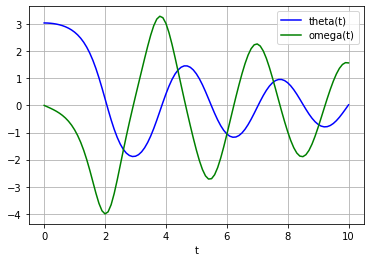

In [3]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 101)
sol = odeint(pend, y0, t, args=(b, c))

plt.plot(t, sol[:, 0], 'b', label='theta(t)')
plt.plot(t, sol[:, 1], 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
plt.show()

## lmfit and numerical integration

In [7]:
df_mrna = mf.cleanColumns(pd.read_csv("wild.csv"))
df_mrna.head()

,mRNA1,mRNA2,mRNA3,mRNA4,mRNA5,mRNA6,mRNA7,mRNA8
time,,,,,,,,
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10.0,0.099307,0.020844,0.007720,0.781444,0.013691,0.084857,2.404909,0.746052
20.0,0.129347,0.041853,0.007983,0.781449,0.014414,1.000481,2.361672,0.688322
30.0,0.241193,0.088704,0.055608,0.781449,0.065749,1.286064,2.248185,0.621902
40.0,0.436952,0.153115,0.357630,0.781445,0.282754,1.326094,2.102741,0.566512


In [176]:
# Container for data used in calculations
class Container():
    def __init__(self, df_mrna, desc_stg):
        self.df_mrna = df_mrna
        self._stmt_initializations = util.readFile("model_initializations.txt")
        descriptor = gn.GeneDescriptor.parse(desc_stg)
        self.mrna_name = "mRNA%d" % descriptor.ngene
        self._gene_reaction = gn.GeneReaction(descriptor)
        self._gene_reaction.generate()
        self.ngene = descriptor.ngene
        network = gn.GeneNetwork()
        network.update([desc_stg])
        network.generate()
        self.parameters = network.new_parameters
        self.initializeNamespace()  # self.namespace
        self.mrna_kinetics = self.__class__._transformKinetics(
            self._gene_reaction.mrna_kinetics)
        self.protein_kinetics = self.__class__._transformKinetics(
            "a_protein%d*mRNA%d - d_protein%d*P%d;")
     
    @staticmethod
    def _transformKinetics(kinetics):
        new_kinetics = kinetics.replace("^", "**")
        return new_kinetics.replace(";", "")
    
    def updateParameters(self, parameters):
        self.parameters = parameters
        
    def initializeNamespace(self):
        # Initialize simulatin constants
        self.namespace = {}
        valuesdict = self.parameters.valuesdict()
        for name, value in valuesdict.items():
            self.namespace[name] = value
        exec(self._stmt_initializations, self.namespace)

In [177]:
container = Container(df_mrna, "7-7A+6")
calcKinetics(np.repeat(0,9), 10.0, container)

[0.0178636133026099,
 0.008848796300155781,
 0.0017198821132135378,
 0.0009161431000014355,
 0.06743577961581705,
 0.001455210339109492,
 0.007556787671052411,
 0.0,
 0.0]

In [169]:
def calcResiduals(parameters):
    """
    Assumes container is in outer scope.
    """
    container.updateParameters(parameters)
    container.initializeNamespace()
    # Construct initial values
    y0_arr = [container.namespace["P%d" % n] for n in range(1, gn.NUM_GENE+1)]
    y0_arr.insert(0, container.namespace[container.mrna_name])
    times = np.array(df_mrna.index.tolist())
    y_mat = odeint(calcKinetics, y0_arr, times, args=(container,))
    residuals = container.df_mrna[container.mrna_name] - y_mat[:, 0]
    return np.var(residuals)

In [178]:
container = Container(df_mrna, "7+1")
calcResiduals(container.parameters)

0.7403245779636451

In [142]:
def calcKinetics(y, time, container):
    """
    y[0] = mRNA, y[1],...,y[8] = P1...P8
    # outer scoped: , ngene, df_mrna, kinetics_mrna, kinetics_protein, namespace
    """
    # Adjust time
    time = 10*round(time/10)
    # Update the namespae 
    for idx in range(1, 8):
        protein = "P%d" % idx
        container.namespace[protein] = y[idx]
        col = "mRNA%d" % idx
        container.namespace[col] = container.df_mrna.loc[time, col]
    mRNA = "mRNA%d" % container.ngene
    container.namespace[mRNA] = y[0]
    # Calculate the drivatives
    dydt = [eval(container.mrna_kinetics, container.namespace)]
    for idx in range(1, 9):
        statement = container.protein_kinetics % (idx, idx, idx, idx)
        dydt.append(eval(statement, container.namespace))
    return dydt

In [179]:
# Do the integration
y0 = np.repeat(0, gn.NUM_GENE + 1)
t = np.array(df_mrna.index.tolist())
#container = Container(df_mrna, "7-7A+6")
sol = odeint(calcKinetics, y0, t, args=(container,))
# NEXT - WRAP A FITTER AROUND THIS

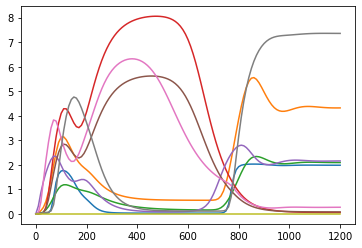

In [180]:
plt.plot(t, sol)

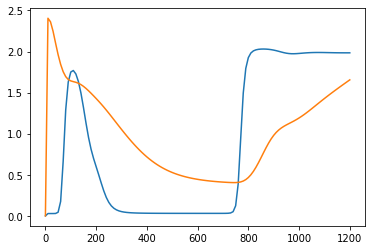

In [182]:
plt.plot(t, sol[:,0], t, df_mrna[container.mrna_name])

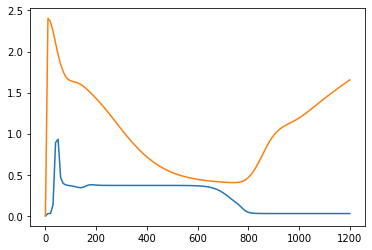

In [153]:
plt.plot(t, sol[:,0], t, df_mrna["mRNA7"])